# Tutorial - visualizzare la KAN

In questo notebook vedremo nel dettaglio come funziona una KAN internamente, prenderemo un record d'esempio, andremo a visualizzare il modo in cui le **spline** vengono modellate in fase di addestramento e come vengono composte in fase di predizione.

Per prima cosa importiamo le librerie necessarie al notebook

In [38]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_dataset as ut
from tfkan import DenseKAN

Prepariamo il dataset per l'addestramento e selezioniamo un record di esempio

In [60]:
x_train = pd.read_csv("datasets/x_train.csv")   # Caricamento del dataset
y_train = pd.read_csv("datasets/y_train.csv")

ut.standardize(x_train)                         # Standardizzazione
x_train = x_train.to_numpy()[:, 1:-1]
y_train = y_train.to_numpy()[:, -1]

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)   # Conversione a tensore
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

my_record = x_train[8]                                      # Selezione del record di esempio

$$
\Phi_{l} = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \cdots & \phi_{1n} \\
\phi_{21} & \phi_{22} & \cdots & \phi_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m1} & \phi_{m2} & \cdots & \phi_{mn}
\end{bmatrix}
$$
Dove 
$$
\phi(x) = w_bb(x) + w_s\sum_i{c_iB_i(x)}
$$

A questo punto possiamo definire l'architettura del modello, compilarlo ed addestrarlo.

Faremo un breve addestramento in quanto ora l'obiettivo non è quello di ottimizzare le prestazioni ma piuttosto quello di illustrare un processo.

In [40]:
input_dim = x_train.shape[1]
layer1_dim = 4
layer2_dim = 1

# Architettura del modello
model = tf.keras.models.Sequential([
    DenseKAN(layer1_dim, grid_range=(-2,2), grid_size=20),
    DenseKAN(layer2_dim)
])

# Costruzione, compilazione e addestramento del modello
model.build(input_shape=(None, input_dim))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 15.4049 - mse: 15.4049
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6145 - mse: 1.6145
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7295 - mse: 0.7295
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6142 - mse: 0.6142
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5479 - mse: 0.5479
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5190 - mse: 0.5190
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5072 - mse: 0.5072
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4755 - mse: 0.4755
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4582 - mse: 0.4582
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4386 - mse: 0.4386


Vediamo ora come è avvenuto il processamento del nostro record nel primo layer del modello.

Per farlo estraiamo le spline del layer con il metodo **get_spline_list()** queste saranno input_dim * layer1\_dim, nel nostro caso 23 * 4 = 92.

Rappresentiamo le spline del livello con una matrice 4 x 23; per ogni riga, ognuna delle 23 spline in colonna prenderà in input l'i-esimo attributo del record d'esempio (qui segnato con una linea rossa) e restituirà in output l'immagine di quell' attributo (qui segnato con una linea verde).

Il tensore passato al livello successivo (di dimensione layer1_dim) avrà come i-esimo valore la somma delle immagini rappresentate nella i-esima riga del livello.

Output del primo livello: [ 0.20045226  0.04853842  0.38547302 -0.29315746]


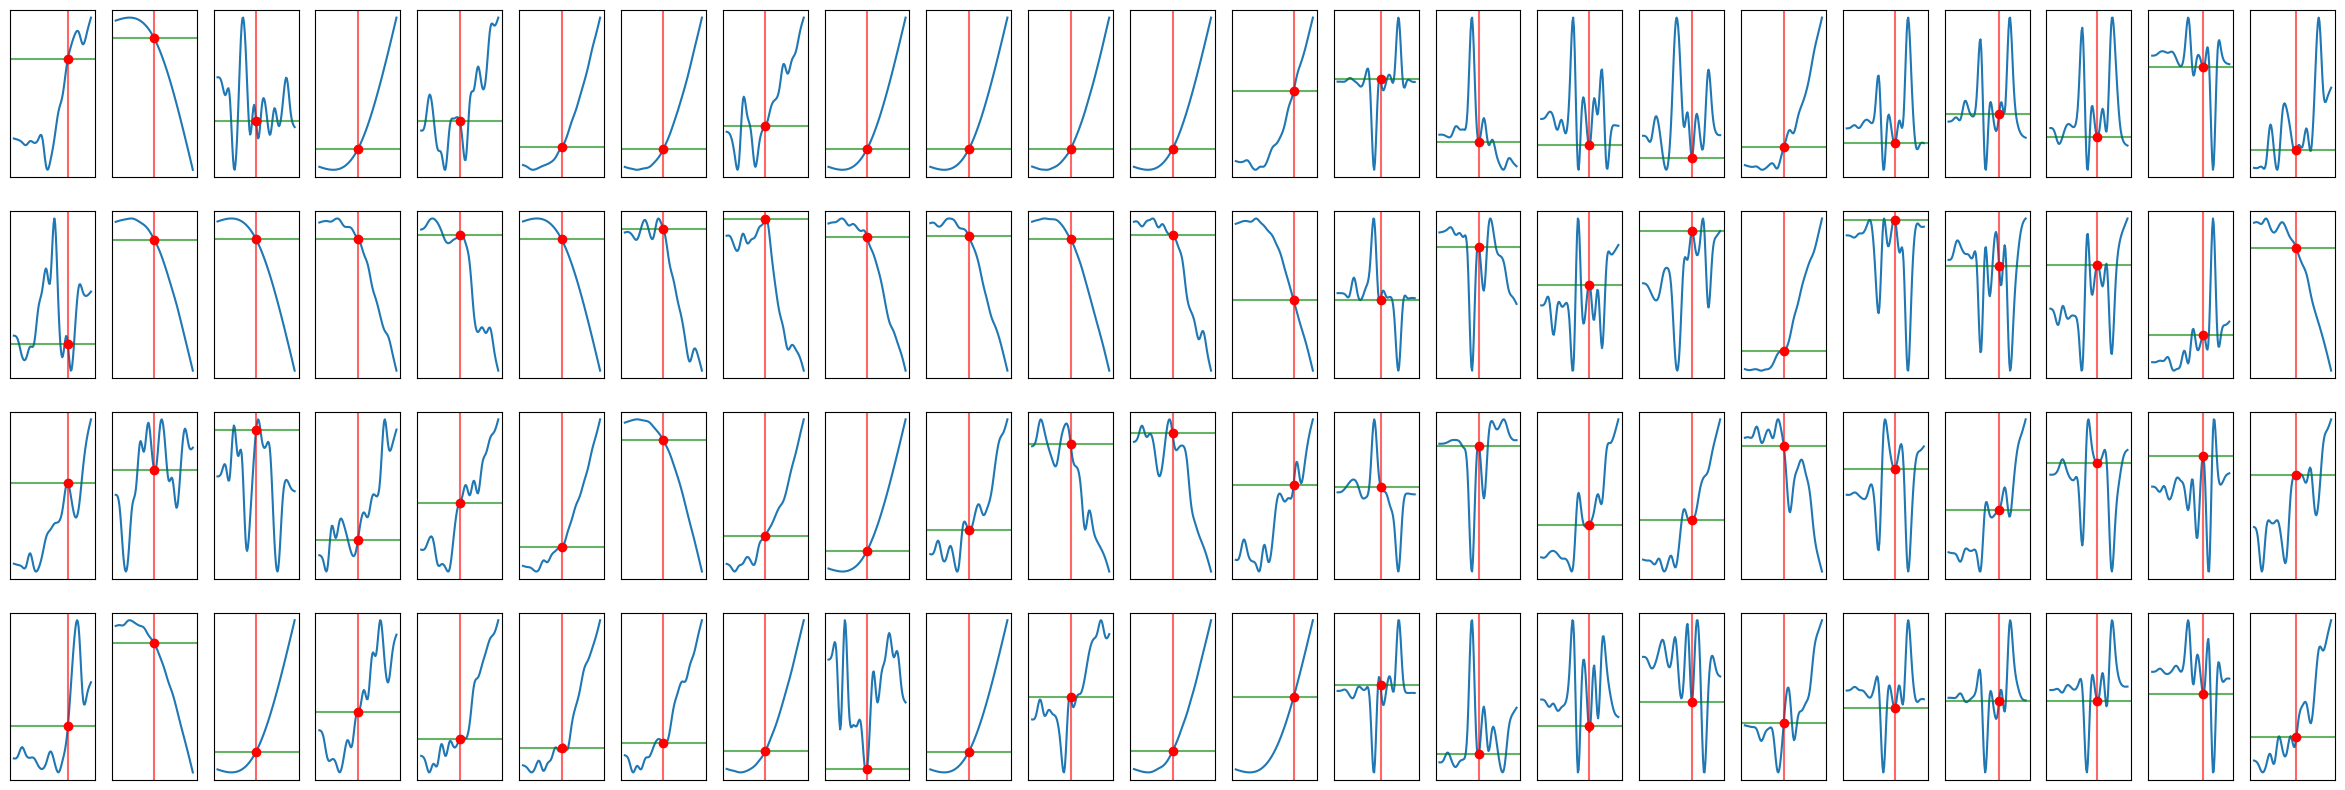

In [53]:
fig, axes = plt.subplots(layer1_dim, input_dim, figsize=(30, 10))   # Preparazione dell'area grafica

spline_list = model.layers[0].get_spline_list()                     # Estrazione delle spline del livello

layer1_output = np.zeros(layer1_dim)    # Output del livello (input del livello successivo)

# Stampa delle spline del livello con le linee che rappresentano attributi e immagini del record
for i in range(layer1_dim):
    for j in range(input_dim):
        xx = np.linspace(-2, 2, 100)
        yy = spline_list[j][i](tf.convert_to_tensor(xx, dtype=tf.float32))
        axes[i][j].plot(xx, yy)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].axvline(x=my_record[j], color='red', alpha=0.6)
        axes[i][j].axhline(y=spline_list[j][i](my_record[j]), color='green', alpha=0.6)
        axes[i][j].plot(my_record[j], spline_list[j][i](my_record[j]), 'ro')
        layer1_output[i] += spline_list[j][i](my_record[j])

print(f"Output del primo livello: {layer1_output}")

plt.show()

$$
KAN(x) = \sum_{i_{1}=1}^{5}{\phi_{1}(\sum_{i_{0}=1}^{26}{\phi_{0}(x_{i_0})})}
$$

Passando ora al secondo livello, che ha dimensione 4 * 1 = 4, ripetiamo il processo e vediamo il valore che la rete restituisce in output

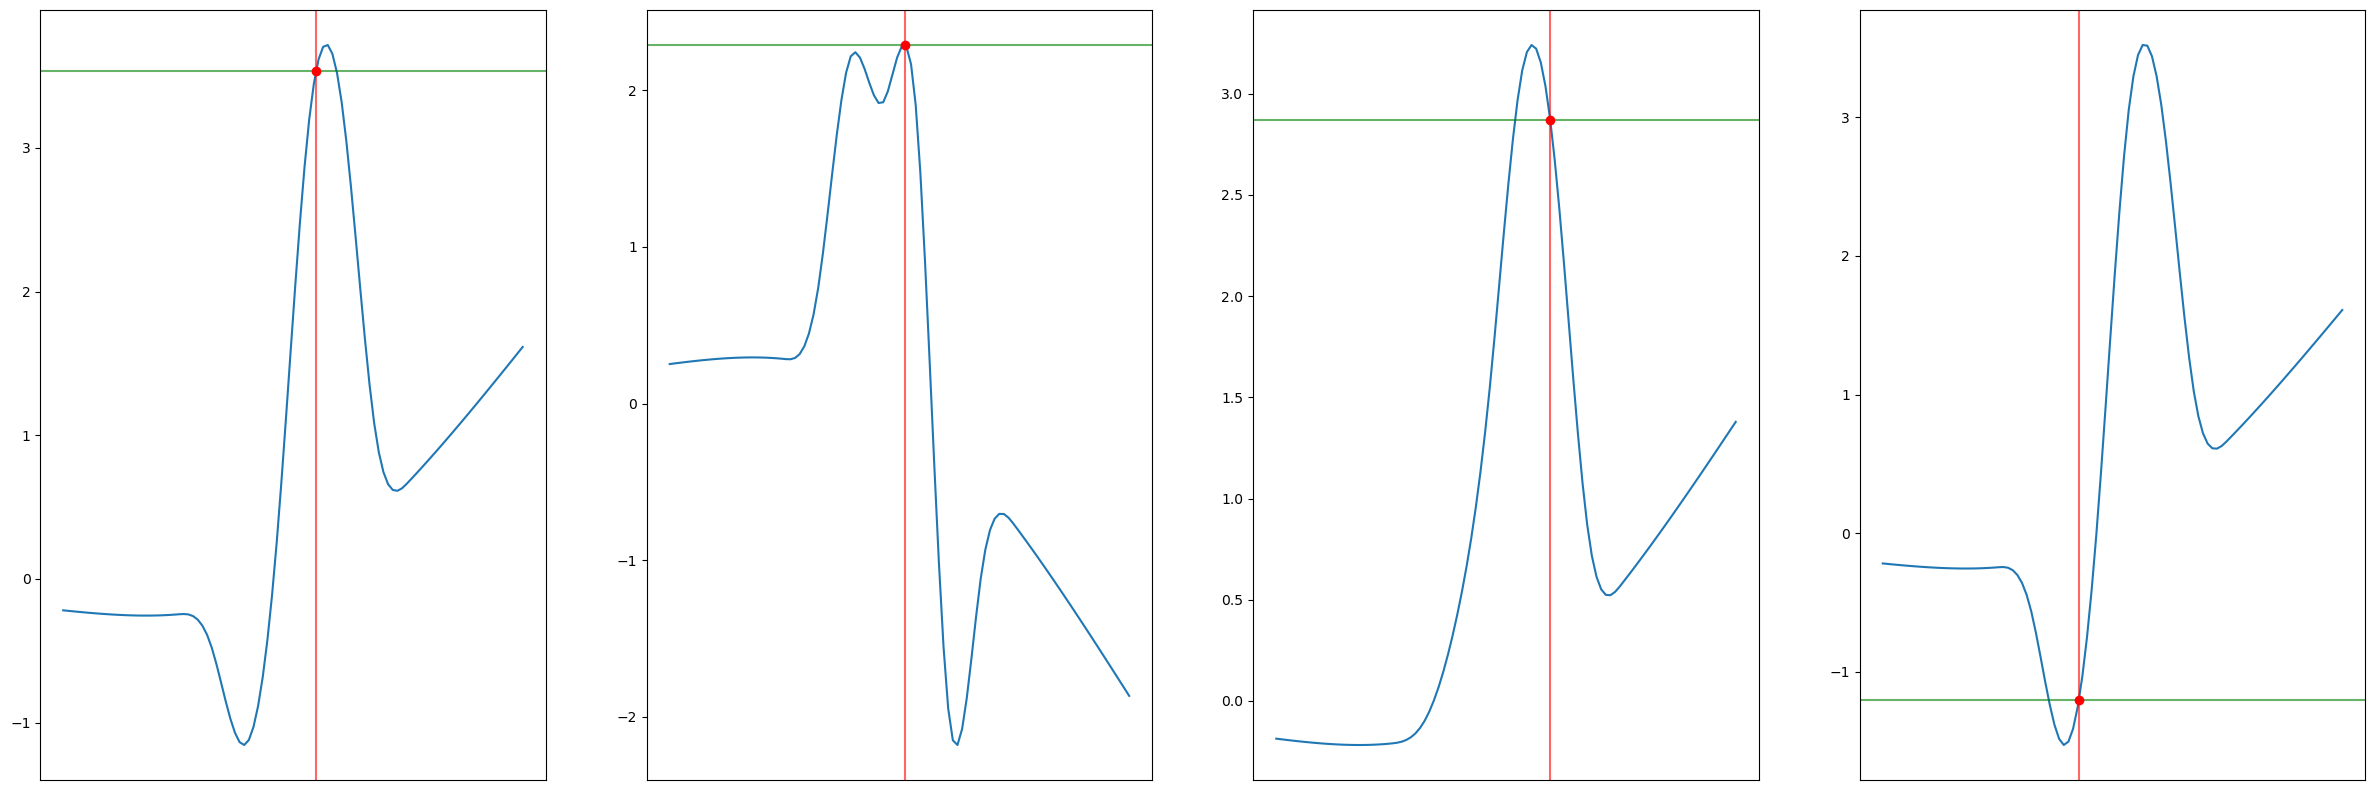

Predizione della rete: 7.486349940299988, label reale: 8.0


In [59]:
fig, axes = plt.subplots(layer2_dim, layer1_dim, figsize=(30, 10), squeeze=False)

spline_list_1 = model.layers[1].get_spline_list()

layer2_output = 0

for i in range(layer2_dim):
    for j in range(layer1_dim):
        xx = np.linspace(-2, 2, 100)
        yy = spline_list_1[j][i](tf.convert_to_tensor(xx, dtype=tf.float32))
        axes[i][j].plot(xx, yy)
        axes[i][j].set_xticks([])
        axes[i][j].axvline(x=layer1_output[j], color='red', alpha=0.6)
        axes[i][j].axhline(y=spline_list_1[j][i](layer1_output[j]), color='green', alpha=0.6)
        axes[i][j].plot(layer1_output[j], spline_list_1[j][i](layer1_output[j]), 'ro')
        layer2_output += spline_list_1[j][i](layer1_output[j])

plt.show()

print(f"Predizione della rete: {layer2_output}, label reale: {y_train[8]}")